In [12]:
import pandas as pd
import numpy as np
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import random

# Read the CSV data
df = pd.read_csv('filtered_file.csv')

def get_data_for_combination(df, size, distance):
    return df[(df['Size'] == size) & (df['Distance_x'] == distance)]

def calculate_total_cost(row):
    return row['insurance_cost'] + row['maintenance_cost'] + row['fuel_costs'] + row['Cost']

def evaluate_solution(individual, data):
    vehicle_index = individual[0]
    if vehicle_index >= len(data):
        return float('inf'), float('inf')
    
    selected_vehicle = data.iloc[vehicle_index]
    total_cost = calculate_total_cost(selected_vehicle)
    carbon_emission = selected_vehicle['carbon_emissions']
    
    return total_cost, carbon_emission

def optimize_for_combination(size, distance, df):
    # Filter data for the specific combination
    subset_data = get_data_for_combination(df, size, distance)
    
    if len(subset_data) == 0:
        return None
    
    # Create fitness and individual classes
    creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
    creator.create("Individual", list, fitness=creator.FitnessMin)
    
    # Initialize toolbox
    toolbox = base.Toolbox()
    toolbox.register("indices", random.randint, 0, len(subset_data)-1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.indices, n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    # Register genetic operators
    toolbox.register("evaluate", evaluate_solution, data=subset_data)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutUniformInt, low=0, up=len(subset_data)-1, indpb=0.1)
    toolbox.register("select", tools.selNSGA2)
    
    # Create initial population
    population = toolbox.population(n=50)
    
    # Run NSGA-II
    algorithms.eaMuPlusLambda(population, toolbox, mu=50, lambda_=100,
                             cxpb=0.7, mutpb=0.3, ngen=50,
                             verbose=False)
    
    # Get Pareto front
    pareto_front = tools.sortNondominated(population, len(population), first_front_only=True)[0]
    
    return [(ind.fitness.values[0], ind.fitness.values[1]) for ind in pareto_front]

def plot_pareto_fronts(results):
    plt.figure(figsize=(12, 8))
    
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    markers = ['o', 's', '^', 'v', '<', '>', 'p']
    
    for idx, (combination, front) in enumerate(results.items()):
        if front:
            costs, emissions = zip(*front)
            plt.scatter(costs, emissions, 
                       label=f'Size {combination[0]}, Distance {combination[1]}',
                       color=colors[idx % len(colors)],
                       marker=markers[idx % len(markers)])
    
    plt.xlabel('Total Cost ($)')
    plt.ylabel('Carbon Emissions')
    plt.title('Pareto Fronts for Different Size-Distance Combinations')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main execution
def main():
    # Get unique combinations of Size and Distance
    combinations = df[['Size', 'Distance_x']].drop_duplicates().values.tolist()
    
    # Store results for each combination
    results = {}
    
    for size, distance in combinations:
        front = optimize_for_combination(size, distance, df)
        if front:
            results[(size, distance)] = front
    
    # Plot results
    plot_pareto_fronts(results)

if __name__ == "__main__":
    main()

ValueError: empty range for randrange() (1, 1, 0)

Optimizing for Size S1, Distance D1
Optimizing for Size S1, Distance D2
Optimizing for Size S1, Distance D3
Optimizing for Size S1, Distance D4
Optimizing for Size S2, Distance D1
Optimizing for Size S2, Distance D2
Optimizing for Size S2, Distance D3
Optimizing for Size S2, Distance D4
Optimizing for Size S4, Distance D1
Optimizing for Size S4, Distance D2
Optimizing for Size S4, Distance D3
Optimizing for Size S4, Distance D4
Optimizing for Size S3, Distance D1
Optimizing for Size S3, Distance D2
Optimizing for Size S3, Distance D3
Optimizing for Size S3, Distance D4


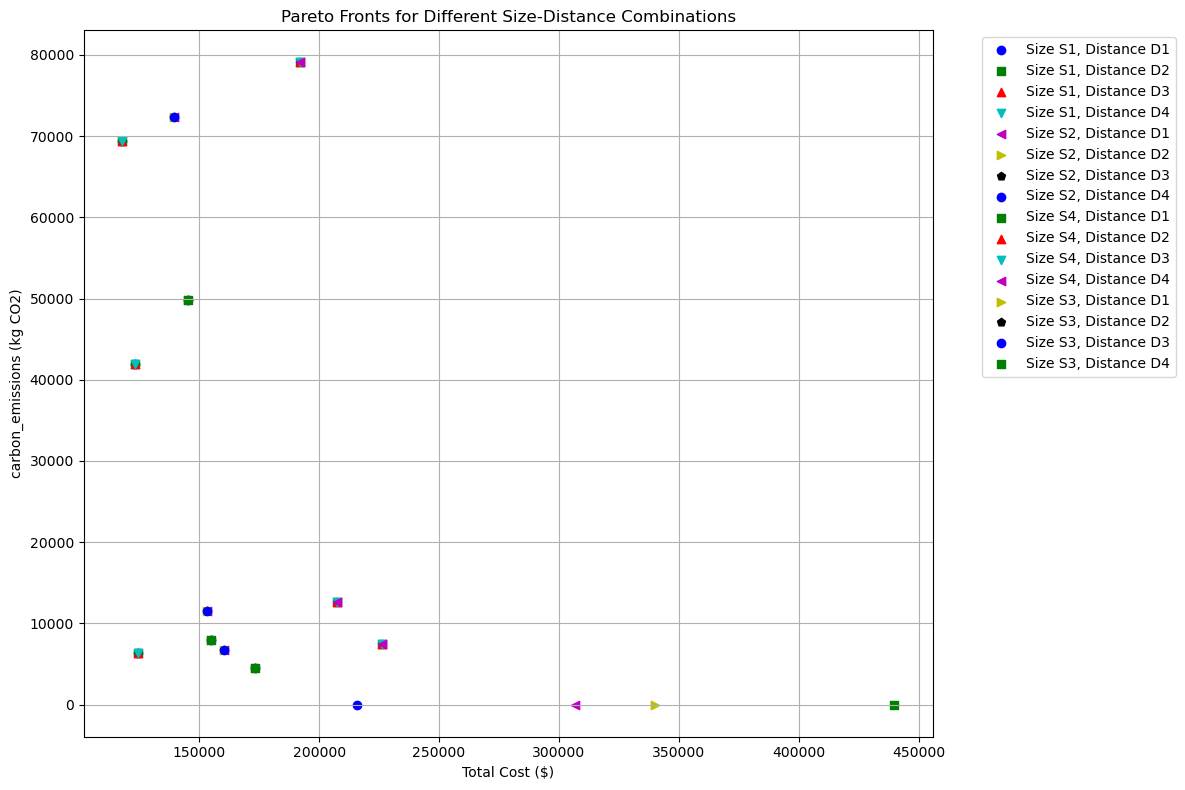

In [16]:
import pandas as pd
import numpy as np
from deap import base, creator, tools
import matplotlib.pyplot as plt
import random

# Clear any existing DEAP creators to avoid conflicts
if 'FitnessMin' in creator.__dict__:
    del creator.FitnessMin
if 'Individual' in creator.__dict__:
    del creator.Individual

def load_and_prepare_data(df):
    """Prepare the data by ensuring correct types and column names"""
    df = df.copy()
    numeric_columns = ['Cost', 'insurance_cost', 'maintenance_cost', 'fuel_costs', 'carbon_emissions']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def calculate_objectives(vehicle):
    """Calculate the two objectives for a vehicle"""
    total_cost = (vehicle['insurance_cost'] + 
                 vehicle['maintenance_cost'] + 
                 vehicle['fuel_costs'] + 
                 vehicle['Cost'])
    carbon_emission = float(vehicle['carbon_emissions'])
    return total_cost, carbon_emission

def find_pareto_optimal(vehicles_data):
    """Find Pareto optimal solutions directly without genetic algorithm"""
    if len(vehicles_data) == 0:
        return []
    
    solutions = []
    for _, vehicle in vehicles_data.iterrows():
        total_cost, carbon_emission = calculate_objectives(vehicle)
        solutions.append((total_cost, carbon_emission))
    
    # Find Pareto optimal solutions
    pareto_optimal = []
    for i, sol1 in enumerate(solutions):
        is_dominated = False
        for j, sol2 in enumerate(solutions):
            if i != j:
                if (sol2[0] <= sol1[0] and sol2[1] < sol1[1]) or \
                   (sol2[0] < sol1[0] and sol2[1] <= sol1[1]):
                    is_dominated = True
                    break
        if not is_dominated:
            pareto_optimal.append(sol1)
    
    return pareto_optimal

def optimize_for_combination(size, distance, df):
    """Find optimal solutions for a specific size-distance combination"""
    try:
        # Filter data for the specific combination
        subset_data = df[(df['Size'] == size) & (df['Distance_x'] == distance)]
        
        if len(subset_data) == 0:
            print(f"No data found for Size {size}, Distance {distance}")
            return None
            
        # Find Pareto optimal solutions
        pareto_front = find_pareto_optimal(subset_data)
        
        if not pareto_front:
            print(f"No valid solutions found for Size {size}, Distance {distance}")
            return None
            
        return pareto_front
        
    except Exception as e:
        print(f"Error in optimization for Size {size}, Distance {distance}: {str(e)}")
        return None

def plot_pareto_fronts(results):
    """Plot the Pareto fronts for all size-distance combinations"""
    plt.figure(figsize=(12, 8))
    
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    markers = ['o', 's', '^', 'v', '<', '>', 'p']
    
    for idx, (combination, front) in enumerate(results.items()):
        if front:
            costs, emissions = zip(*front)
            plt.scatter(costs, emissions, 
                       label=f'Size {combination[0]}, Distance {combination[1]}',
                       color=colors[idx % len(colors)],
                       marker=markers[idx % len(markers)])
    
    plt.xlabel('Total Cost ($)')
    plt.ylabel('carbon_emissions (kg CO2)')
    plt.title('Pareto Fronts for Different Size-Distance Combinations')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main(df):
    """Main function to run the optimization"""
    # Prepare the data
    df = load_and_prepare_data(df)
    
    # Get unique combinations of Size and Distance
    combinations = df[['Size', 'Distance_x']].drop_duplicates().values.tolist()
    
    # Store results for each combination
    results = {}
    
    for size, distance in combinations:
        print(f"Optimizing for Size {size}, Distance {distance}")
        front = optimize_for_combination(size, distance, df)
        if front:
            results[(size, distance)] = front
    
    # Plot results
    if results:
        plot_pareto_fronts(results)
        return results
    else:
        print("No valid results found for any combination")
        return None

if __name__ == "__main__":
    # Example usage with the data from the image
    df = pd.read_csv("filtered_file.csv")
    results = main(df)

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_pareto_fronts(results):
    """Plot the Pareto fronts with enhanced visualization"""
    # Set the style
    plt.style.use('seaborn')
    
    # Create figure with higher resolution and larger size
    plt.figure(figsize=(15, 10), dpi=100)
    
    # Create a distinct color palette using seaborn
    colors = sns.color_palette("husl", len(results))
    
    # Different marker styles and sizes
    markers = ['o', 's', '^', 'v', 'D', '<', '>', 'p', 'h', '8', '*', 'H', 'd']
    sizes = [100, 120, 140, 160]  # Different sizes for better visibility
    
    # Plot each Pareto front
    for idx, ((size, distance), front) in enumerate(results.items()):
        if front:
            costs, emissions = zip(*front)
            plt.scatter(costs, emissions,
                       label=f'Size {size}, Distance {distance}',
                       color=colors[idx],
                       marker=markers[idx % len(markers)],
                       s=sizes[idx % len(sizes)],
                       alpha=0.7,
                       edgecolors='white',
                       linewidth=1)
    
    # Customize the plot
    plt.xlabel('Total Cost ($)', fontsize=12, fontweight='bold')
    plt.ylabel('Carbon Emissions (kg CO2)', fontsize=12, fontweight='bold')
    plt.title('Pareto Fronts for Different Size-Distance Combinations', 
              fontsize=14, fontweight='bold', pad=20)
    
    # Customize grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Customize legend
    plt.legend(bbox_to_anchor=(1.05, 1),
              loc='upper left',
              borderaxespad=0.,
              frameon=True,
              fontsize=10,
              edgecolor='black')
    
    # Customize ticks
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    # Format axis labels with thousands separator
    ax = plt.gca()
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Add a light box around the plot
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['right'].set_linewidth(0.5)
    ax.spines['top'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Show the plot
    plt.show()

Optimizing for Size S1, Distance D1
Optimizing for Size S1, Distance D2
Optimizing for Size S1, Distance D3
Optimizing for Size S1, Distance D4
Optimizing for Size S2, Distance D1
Optimizing for Size S2, Distance D2
Optimizing for Size S2, Distance D3
Optimizing for Size S2, Distance D4
Optimizing for Size S4, Distance D1
Optimizing for Size S4, Distance D2
Optimizing for Size S4, Distance D3
Optimizing for Size S4, Distance D4
Optimizing for Size S3, Distance D1
Optimizing for Size S3, Distance D2
Optimizing for Size S3, Distance D3
Optimizing for Size S3, Distance D4


C:\Users\hjain\AppData\Local\Temp\ipykernel_6488\4249977999.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


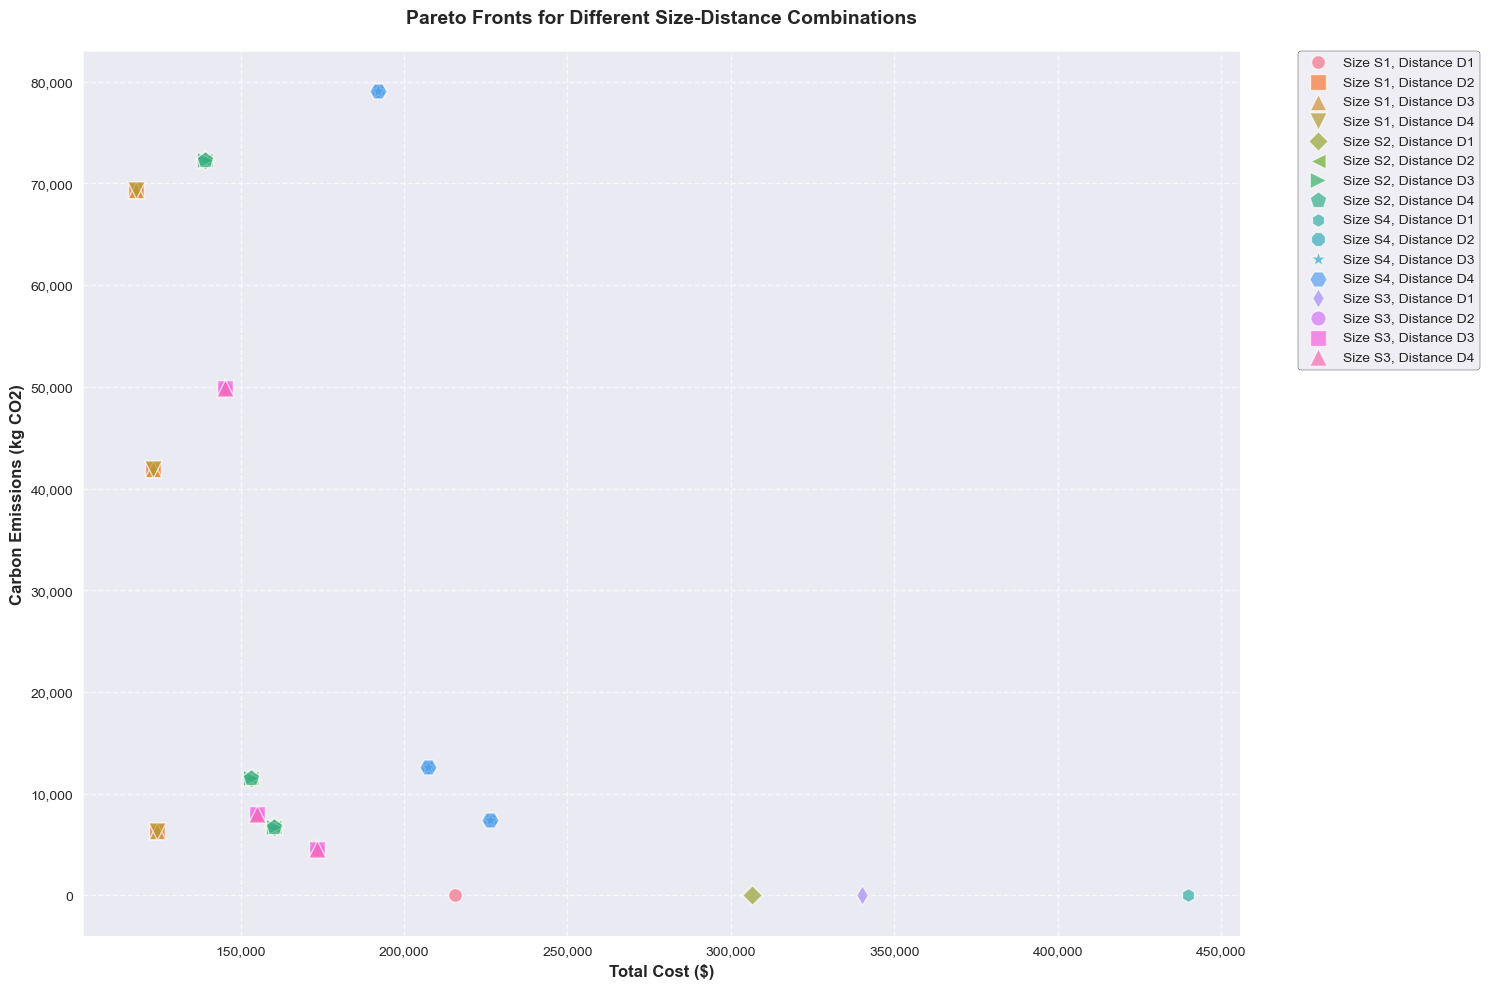

In [18]:
def main(df):
    """Main function to run the optimization"""
    # Prepare the data
    df = load_and_prepare_data(df)
    
    # Get unique combinations of Size and Distance
    combinations = df[['Size', 'Distance_x']].drop_duplicates().values.tolist()
    
    # Store results for each combination
    results = {}
    
    for size, distance in combinations:
        print(f"Optimizing for Size {size}, Distance {distance}")
        front = optimize_for_combination(size, distance, df)
        if front:
            results[(size, distance)] = front
    
    # Plot results
    if results:
        plot_pareto_fronts(results)
        return results
    else:
        print("No valid results found for any combination")
        return None

if __name__ == "__main__":
    # Example usage with the data from the image
    df = pd.read_csv("filtered_file.csv")
    results = main(df)

Optimizing for Size S1, Distance D1
Pareto Optimal Vehicles:
       Allocation  Year Size Distance_x  Demand (km)              ID Vehicle  \
0     BEV_S1_2023  2023   S1         D1       869181     BEV_S1_2023     BEV   
1  Diesel_S1_2023  2023   S1         D1       869181  Diesel_S1_2023  Diesel   
3     LNG_S1_2023  2023   S1         D1       869181     LNG_S1_2023     LNG   
4     LNG_S1_2023  2023   S1         D1       869181     LNG_S1_2023     LNG   

   Cost ($)  Yearly range (km) Distance_y  Operating Year         Fuel  \
0    187000             102000         D1            2023  Electricity   
1     85000             102000         D4            2023          B20   
3    100000             102000         D4            2023          LNG   
4    100000             102000         D4            2023       BioLNG   

   carbon_emissions  insurance_cost  maintenance_cost    fuel_costs Type  \
0          0.000000          9350.0            1870.0  17470.316221  Buy   
1      69347.97

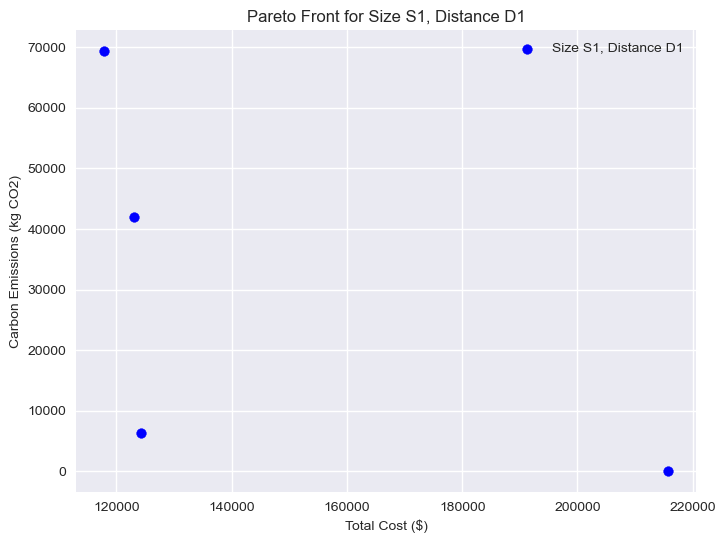

Optimizing for Size S1, Distance D2
Pareto Optimal Vehicles:
       Allocation  Year Size Distance_x  Demand (km)              ID Vehicle  \
5  Diesel_S1_2023  2023   S1         D2      2597094  Diesel_S1_2023  Diesel   
7     LNG_S1_2023  2023   S1         D2      2597094     LNG_S1_2023     LNG   
8     LNG_S1_2023  2023   S1         D2      2597094     LNG_S1_2023     LNG   

   Cost ($)  Yearly range (km) Distance_y  Operating Year    Fuel  \
5     85000             102000         D4            2023     B20   
7    100000             102000         D4            2023     LNG   
8    100000             102000         D4            2023  BioLNG   

   carbon_emissions  insurance_cost  maintenance_cost    fuel_costs Type  \
5      69347.975963          4250.0             850.0  27771.219051  Buy   
7      41971.148530          5000.0            1000.0  17077.879517  Buy   
8       6375.265894          5000.0            1000.0  18325.652865  Buy   

       Cost  
5   85000.0  
7  10000

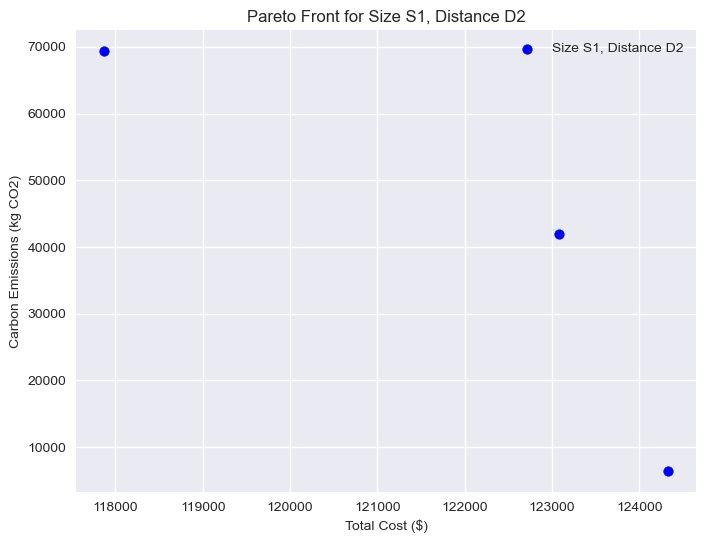

Optimizing for Size S1, Distance D3
Pareto Optimal Vehicles:
        Allocation  Year Size Distance_x  Demand (km)              ID Vehicle  \
9   Diesel_S1_2023  2023   S1         D3      3292011  Diesel_S1_2023  Diesel   
11     LNG_S1_2023  2023   S1         D3      3292011     LNG_S1_2023     LNG   
12     LNG_S1_2023  2023   S1         D3      3292011     LNG_S1_2023     LNG   

    Cost ($)  Yearly range (km) Distance_y  Operating Year    Fuel  \
9      85000             102000         D4            2023     B20   
11    100000             102000         D4            2023     LNG   
12    100000             102000         D4            2023  BioLNG   

    carbon_emissions  insurance_cost  maintenance_cost    fuel_costs Type  \
9       69347.975963          4250.0             850.0  27771.219051  Buy   
11      41971.148530          5000.0            1000.0  17077.879517  Buy   
12       6375.265894          5000.0            1000.0  18325.652865  Buy   

        Cost  
9    8500

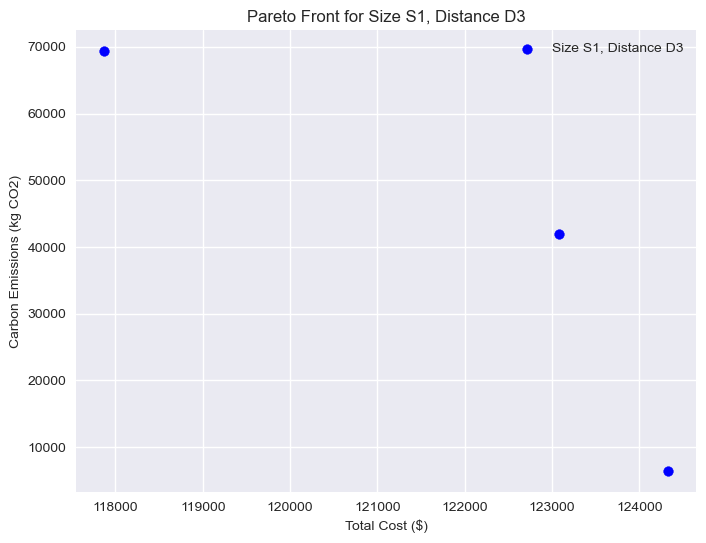

Optimizing for Size S1, Distance D4
Pareto Optimal Vehicles:
        Allocation  Year Size Distance_x  Demand (km)              ID Vehicle  \
13  Diesel_S1_2023  2023   S1         D4       414315  Diesel_S1_2023  Diesel   
15     LNG_S1_2023  2023   S1         D4       414315     LNG_S1_2023     LNG   
16     LNG_S1_2023  2023   S1         D4       414315     LNG_S1_2023     LNG   

    Cost ($)  Yearly range (km) Distance_y  Operating Year    Fuel  \
13     85000             102000         D4            2023     B20   
15    100000             102000         D4            2023     LNG   
16    100000             102000         D4            2023  BioLNG   

    carbon_emissions  insurance_cost  maintenance_cost    fuel_costs Type  \
13      69347.975963          4250.0             850.0  27771.219051  Buy   
15      41971.148530          5000.0            1000.0  17077.879517  Buy   
16       6375.265894          5000.0            1000.0  18325.652865  Buy   

        Cost  
13   8500

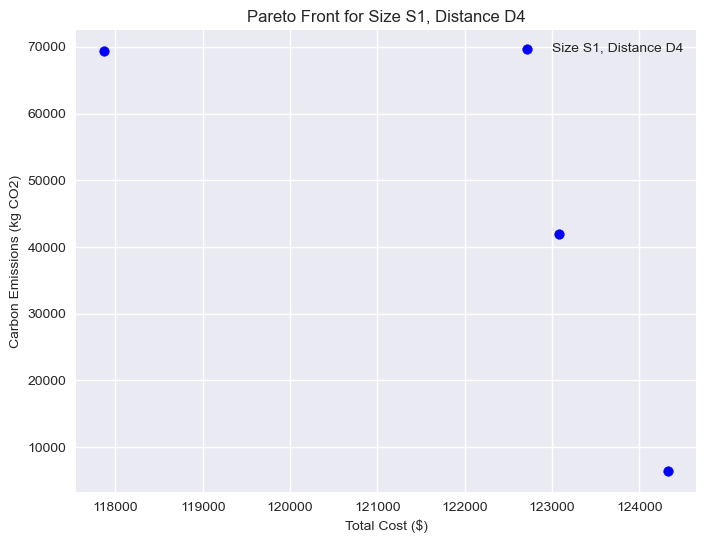

Optimizing for Size S2, Distance D1
Pareto Optimal Vehicles:
        Allocation  Year Size Distance_x  Demand (km)              ID Vehicle  \
17     BEV_S2_2023  2023   S2         D1       995694     BEV_S2_2023     BEV   
18  Diesel_S2_2023  2023   S2         D1       995694  Diesel_S2_2023  Diesel   
19  Diesel_S2_2023  2023   S2         D1       995694  Diesel_S2_2023  Diesel   
21     LNG_S2_2023  2023   S2         D1       995694     LNG_S2_2023     LNG   

    Cost ($)  Yearly range (km) Distance_y  Operating Year         Fuel  \
17    272000             106000         D1            2023  Electricity   
18    104000             106000         D4            2023          B20   
19    104000             106000         D4            2023          HVO   
21    133000             106000         D4            2023       BioLNG   

    carbon_emissions  insurance_cost  maintenance_cost    fuel_costs Type  \
17          0.000000         13600.0            2720.0  18231.805893  Buy   
18 

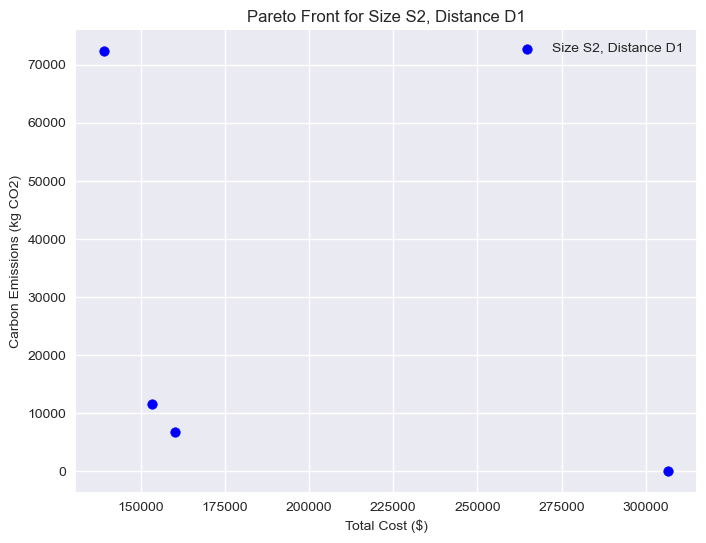

Optimizing for Size S2, Distance D2
Pareto Optimal Vehicles:
        Allocation  Year Size Distance_x  Demand (km)              ID Vehicle  \
22  Diesel_S2_2023  2023   S2         D2      1383196  Diesel_S2_2023  Diesel   
23  Diesel_S2_2023  2023   S2         D2      1383196  Diesel_S2_2023  Diesel   
25     LNG_S2_2023  2023   S2         D2      1383196     LNG_S2_2023     LNG   

    Cost ($)  Yearly range (km) Distance_y  Operating Year    Fuel  \
22    104000             106000         D4            2023     B20   
23    104000             106000         D4            2023     HVO   
25    133000             106000         D4            2023  BioLNG   

    carbon_emissions  insurance_cost  maintenance_cost    fuel_costs Type  \
22      72337.657397          5200.0            1040.0  28968.472422  Buy   
23      11570.494411          5200.0            1040.0  43050.513745  Buy   
25       6706.548367          6650.0            1330.0  19277.921790  Buy   

        Cost  
22  10400

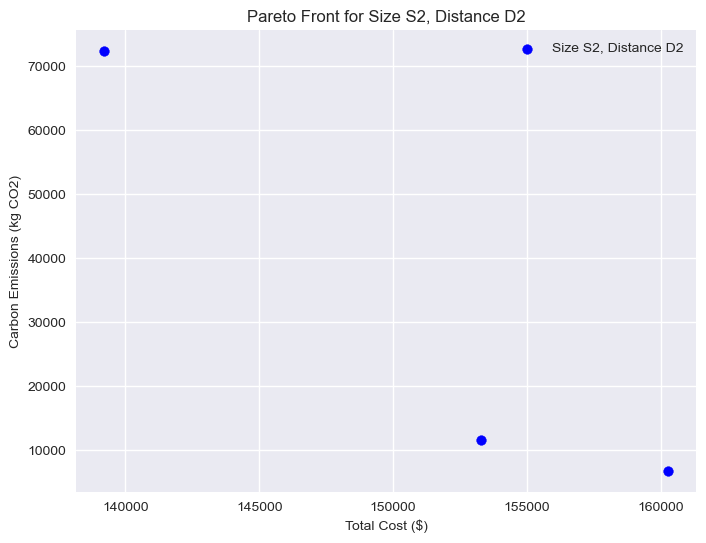

Optimizing for Size S2, Distance D3
Pareto Optimal Vehicles:
        Allocation  Year Size Distance_x  Demand (km)              ID Vehicle  \
26  Diesel_S2_2023  2023   S2         D3       778008  Diesel_S2_2023  Diesel   
27  Diesel_S2_2023  2023   S2         D3       778008  Diesel_S2_2023  Diesel   
29     LNG_S2_2023  2023   S2         D3       778008     LNG_S2_2023     LNG   

    Cost ($)  Yearly range (km) Distance_y  Operating Year    Fuel  \
26    104000             106000         D4            2023     B20   
27    104000             106000         D4            2023     HVO   
29    133000             106000         D4            2023  BioLNG   

    carbon_emissions  insurance_cost  maintenance_cost    fuel_costs Type  \
26      72337.657397          5200.0            1040.0  28968.472422  Buy   
27      11570.494411          5200.0            1040.0  43050.513745  Buy   
29       6706.548367          6650.0            1330.0  19277.921790  Buy   

        Cost  
26  10400

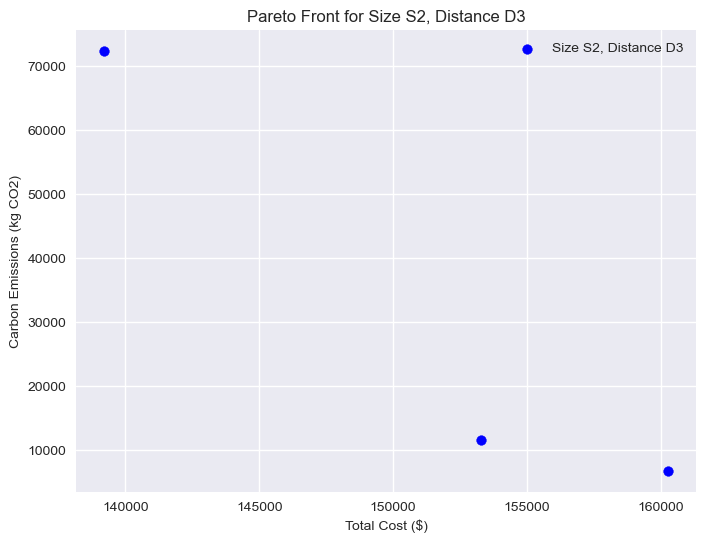

Optimizing for Size S2, Distance D4
Pareto Optimal Vehicles:
        Allocation  Year Size Distance_x  Demand (km)              ID Vehicle  \
30  Diesel_S2_2023  2023   S2         D4       133677  Diesel_S2_2023  Diesel   
31  Diesel_S2_2023  2023   S2         D4       133677  Diesel_S2_2023  Diesel   
33     LNG_S2_2023  2023   S2         D4       133677     LNG_S2_2023     LNG   

    Cost ($)  Yearly range (km) Distance_y  Operating Year    Fuel  \
30    104000             106000         D4            2023     B20   
31    104000             106000         D4            2023     HVO   
33    133000             106000         D4            2023  BioLNG   

    carbon_emissions  insurance_cost  maintenance_cost    fuel_costs Type  \
30      72337.657397          5200.0            1040.0  28968.472422  Buy   
31      11570.494411          5200.0            1040.0  43050.513745  Buy   
33       6706.548367          6650.0            1330.0  19277.921790  Buy   

        Cost  
30  10400

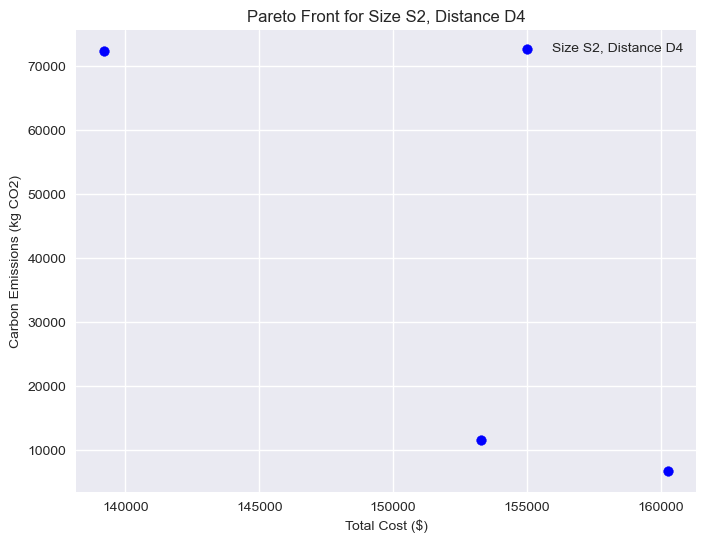

Optimizing for Size S4, Distance D1
Pareto Optimal Vehicles:
        Allocation  Year Size Distance_x  Demand (km)              ID Vehicle  \
34     BEV_S4_2023  2023   S4         D1        14576     BEV_S4_2023     BEV   
35  Diesel_S4_2023  2023   S4         D1        14576  Diesel_S4_2023  Diesel   
36  Diesel_S4_2023  2023   S4         D1        14576  Diesel_S4_2023  Diesel   
38     LNG_S4_2023  2023   S4         D1        14576     LNG_S4_2023     LNG   

    Cost ($)  Yearly range (km) Distance_y  Operating Year         Fuel  \
34    395636             118000         D1            2023  Electricity   
35    151272             118000         D4            2023          B20   
36    151272             118000         D4            2023          HVO   
38    193454             118000         D4            2023       BioLNG   

    carbon_emissions  insurance_cost  maintenance_cost    fuel_costs Type  \
34          0.000000         19781.8           3956.36  20383.231408  Buy   
35 

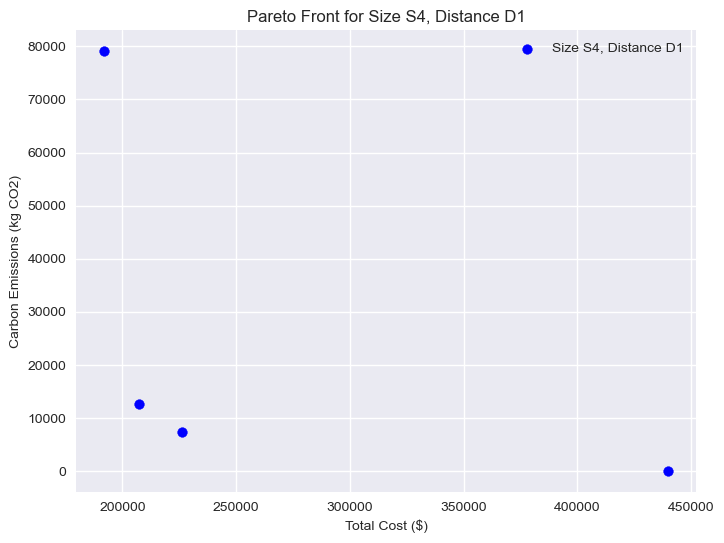

Optimizing for Size S4, Distance D2
Pareto Optimal Vehicles:
        Allocation  Year Size Distance_x  Demand (km)              ID Vehicle  \
39  Diesel_S4_2023  2023   S4         D2       754717  Diesel_S4_2023  Diesel   
40  Diesel_S4_2023  2023   S4         D2       754717  Diesel_S4_2023  Diesel   
42     LNG_S4_2023  2023   S4         D2       754717     LNG_S4_2023     LNG   

    Cost ($)  Yearly range (km) Distance_y  Operating Year    Fuel  \
39    151272             118000         D4            2023     B20   
40    151272             118000         D4            2023     HVO   
42    193454             118000         D4            2023  BioLNG   

    carbon_emissions  insurance_cost  maintenance_cost    fuel_costs Type  \
39      79078.903088          7563.6           1512.72  31668.084172  Buy   
40      12648.764684          7563.6           1512.72  47062.450276  Buy   
42       7416.792843          9672.7           1934.54  21319.514083  Buy   

        Cost  
39  15127

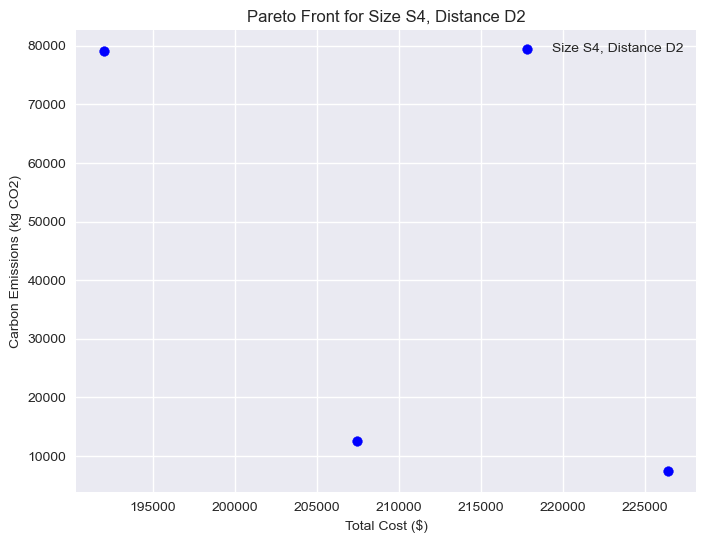

Optimizing for Size S4, Distance D3
Pareto Optimal Vehicles:
        Allocation  Year Size Distance_x  Demand (km)              ID Vehicle  \
43  Diesel_S4_2023  2023   S4         D3       118899  Diesel_S4_2023  Diesel   
44  Diesel_S4_2023  2023   S4         D3       118899  Diesel_S4_2023  Diesel   
46     LNG_S4_2023  2023   S4         D3       118899     LNG_S4_2023     LNG   

    Cost ($)  Yearly range (km) Distance_y  Operating Year    Fuel  \
43    151272             118000         D4            2023     B20   
44    151272             118000         D4            2023     HVO   
46    193454             118000         D4            2023  BioLNG   

    carbon_emissions  insurance_cost  maintenance_cost    fuel_costs Type  \
43      79078.903088          7563.6           1512.72  31668.084172  Buy   
44      12648.764684          7563.6           1512.72  47062.450276  Buy   
46       7416.792843          9672.7           1934.54  21319.514083  Buy   

        Cost  
43  15127

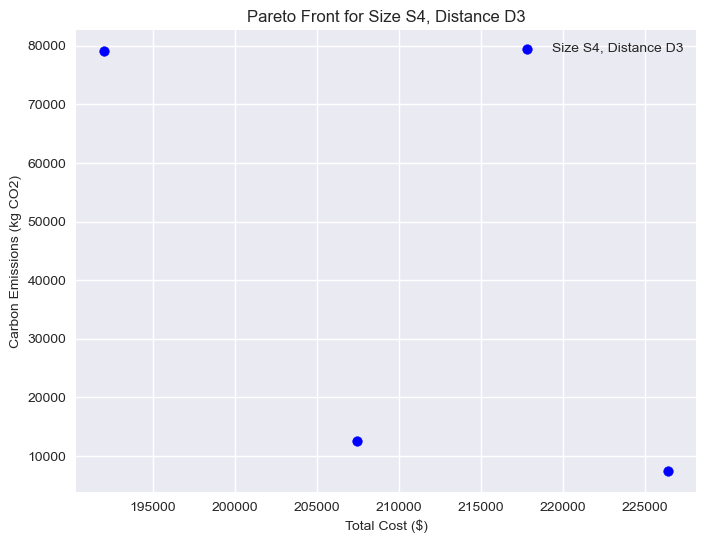

Optimizing for Size S4, Distance D4
Pareto Optimal Vehicles:
        Allocation  Year Size Distance_x  Demand (km)              ID Vehicle  \
47  Diesel_S4_2023  2023   S4         D4         1809  Diesel_S4_2023  Diesel   
48  Diesel_S4_2023  2023   S4         D4         1809  Diesel_S4_2023  Diesel   
50     LNG_S4_2023  2023   S4         D4         1809     LNG_S4_2023     LNG   

    Cost ($)  Yearly range (km) Distance_y  Operating Year    Fuel  \
47    151272             118000         D4            2023     B20   
48    151272             118000         D4            2023     HVO   
50    193454             118000         D4            2023  BioLNG   

    carbon_emissions  insurance_cost  maintenance_cost    fuel_costs Type  \
47      79078.903088          7563.6           1512.72  31668.084172  Buy   
48      12648.764684          7563.6           1512.72  47062.450276  Buy   
50       7416.792843          9672.7           1934.54  21319.514083  Buy   

        Cost  
47  15127

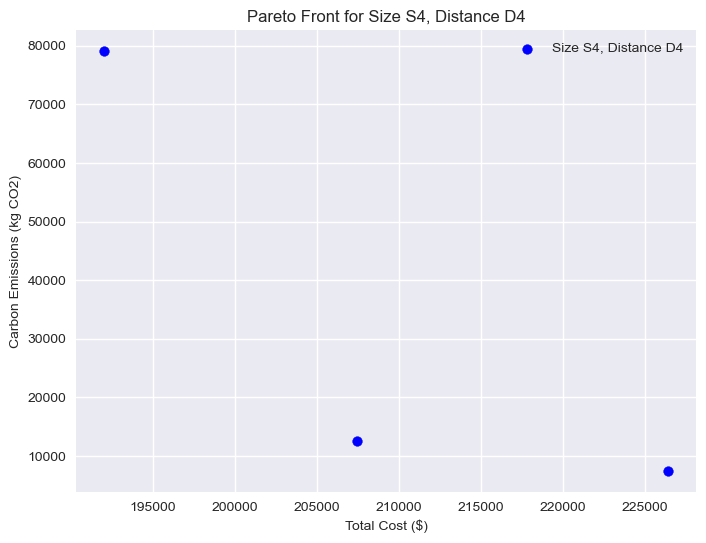

Optimizing for Size S3, Distance D1
Pareto Optimal Vehicles:
        Allocation  Year Size Distance_x  Demand (km)              ID Vehicle  \
51     BEV_S3_2023  2023   S3         D1      2183475     BEV_S3_2023     BEV   
52  Diesel_S3_2023  2023   S3         D1      2183475  Diesel_S3_2023  Diesel   
53  Diesel_S3_2023  2023   S3         D1      2183475  Diesel_S3_2023  Diesel   
55     LNG_S3_2023  2023   S3         D1      2183475     LNG_S3_2023     LNG   

    Cost ($)  Yearly range (km) Distance_y  Operating Year         Fuel  \
51    309090              73000         D1            2023  Electricity   
52    118181              73000         D4            2023          B20   
53    118181              73000         D4            2023          HVO   
55    151136              73000         D4            2023       BioLNG   

    carbon_emissions  insurance_cost  maintenance_cost    fuel_costs Type  \
51          0.000000        15454.50           3090.90  12572.709216  Buy   
52 

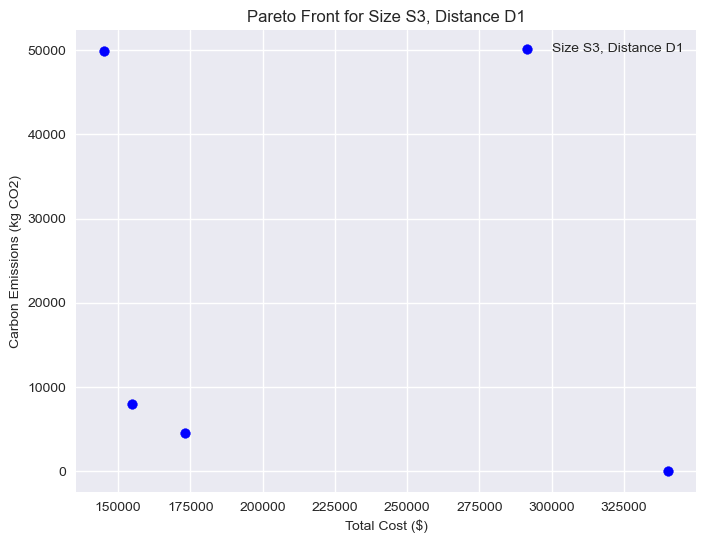

Optimizing for Size S3, Distance D2
Pareto Optimal Vehicles:
        Allocation  Year Size Distance_x  Demand (km)              ID Vehicle  \
56  Diesel_S3_2023  2023   S3         D2      2431901  Diesel_S3_2023  Diesel   
57  Diesel_S3_2023  2023   S3         D2      2431901  Diesel_S3_2023  Diesel   
59     LNG_S3_2023  2023   S3         D2      2431901     LNG_S3_2023     LNG   

    Cost ($)  Yearly range (km) Distance_y  Operating Year    Fuel  \
56    118181              73000         D4            2023     B20   
57    118181              73000         D4            2023     HVO   
59    151136              73000         D4            2023  BioLNG   

    carbon_emissions  insurance_cost  maintenance_cost    fuel_costs Type  \
56      49868.628960         5909.05           1181.81  19970.483628  Buy   
57       7976.546565         5909.05           1181.81  29678.457580  Buy   
59       4549.567924         7556.80           1511.36  13077.698068  Buy   

        Cost  
56  11818

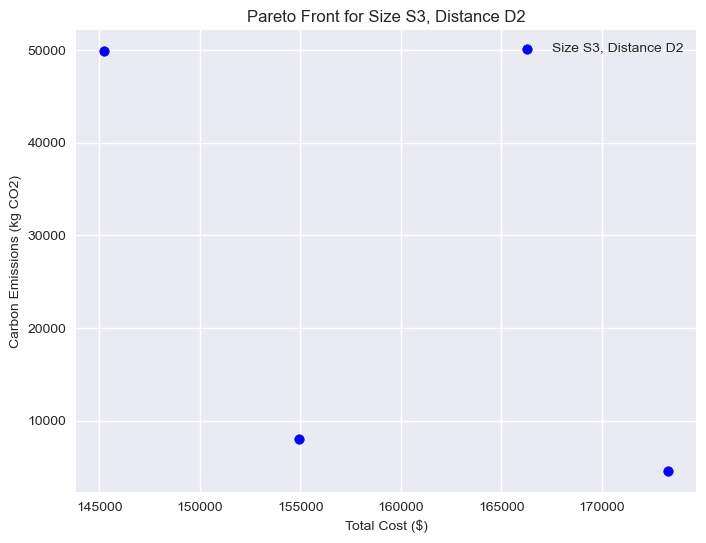

Optimizing for Size S3, Distance D3
Pareto Optimal Vehicles:
        Allocation  Year Size Distance_x  Demand (km)              ID Vehicle  \
60  Diesel_S3_2023  2023   S3         D3      1002466  Diesel_S3_2023  Diesel   
61  Diesel_S3_2023  2023   S3         D3      1002466  Diesel_S3_2023  Diesel   
63     LNG_S3_2023  2023   S3         D3      1002466     LNG_S3_2023     LNG   

    Cost ($)  Yearly range (km) Distance_y  Operating Year    Fuel  \
60    118181              73000         D4            2023     B20   
61    118181              73000         D4            2023     HVO   
63    151136              73000         D4            2023  BioLNG   

    carbon_emissions  insurance_cost  maintenance_cost    fuel_costs Type  \
60      49868.628960         5909.05           1181.81  19970.483628  Buy   
61       7976.546565         5909.05           1181.81  29678.457580  Buy   
63       4549.567924         7556.80           1511.36  13077.698068  Buy   

        Cost  
60  11818

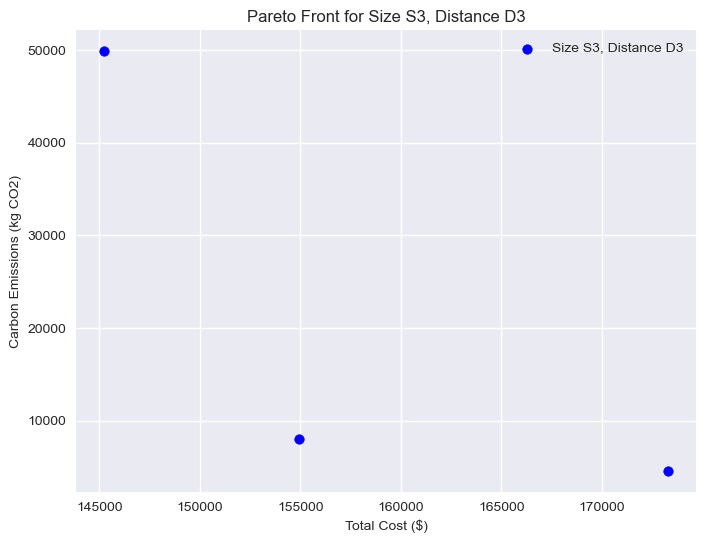

Optimizing for Size S3, Distance D4
Pareto Optimal Vehicles:
        Allocation  Year Size Distance_x  Demand (km)              ID Vehicle  \
64  Diesel_S3_2023  2023   S3         D4       205426  Diesel_S3_2023  Diesel   
65  Diesel_S3_2023  2023   S3         D4       205426  Diesel_S3_2023  Diesel   
67     LNG_S3_2023  2023   S3         D4       205426     LNG_S3_2023     LNG   

    Cost ($)  Yearly range (km) Distance_y  Operating Year    Fuel  \
64    118181              73000         D4            2023     B20   
65    118181              73000         D4            2023     HVO   
67    151136              73000         D4            2023  BioLNG   

    carbon_emissions  insurance_cost  maintenance_cost    fuel_costs Type  \
64      49868.628960         5909.05           1181.81  19970.483628  Buy   
65       7976.546565         5909.05           1181.81  29678.457580  Buy   
67       4549.567924         7556.80           1511.36  13077.698068  Buy   

        Cost  
64  11818

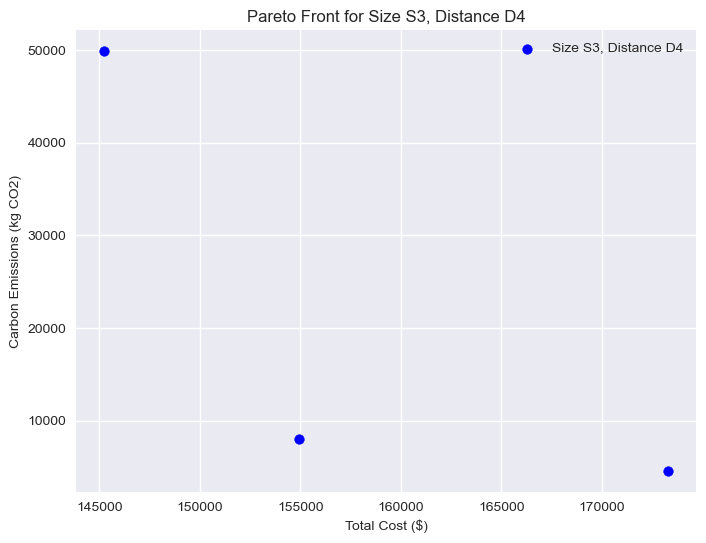

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def load_and_prepare_data(df):
    df = df.copy()
    numeric_columns = ['Cost', 'insurance_cost', 'maintenance_cost', 'fuel_costs', 'carbon_emissions']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df


def calculate_objectives(vehicle):
    total_cost = (
        vehicle['insurance_cost'] + vehicle['maintenance_cost'] + vehicle['fuel_costs'] + vehicle['Cost']
    )
    carbon_emission = float(vehicle['carbon_emissions'])
    return total_cost, carbon_emission


def find_pareto_optimal(vehicles_data):
    if len(vehicles_data) == 0:
        return []
    
    solutions = []
    details = []
    for _, vehicle in vehicles_data.iterrows():
        total_cost, carbon_emission = calculate_objectives(vehicle)
        solutions.append((total_cost, carbon_emission))
        details.append(vehicle)
    
    pareto_optimal = []
    pareto_details = []
    
    for i, sol1 in enumerate(solutions):
        is_dominated = False
        for j, sol2 in enumerate(solutions):
            if i != j:
                if (sol2[0] <= sol1[0] and sol2[1] < sol1[1]) or (sol2[0] < sol1[0] and sol2[1] <= sol1[1]):
                    is_dominated = True
                    break
        if not is_dominated:
            pareto_optimal.append(sol1)
            pareto_details.append(details[i])
    
    return pareto_optimal, pareto_details


def optimize_for_combination(size, distance, df):
    subset_data = df[(df['Size'] == size) & (df['Distance_x'] == distance)]
    
    if len(subset_data) == 0:
        print(f"No data found for Size {size}, Distance {distance}")
        return None, None
    
    pareto_front, pareto_details = find_pareto_optimal(subset_data)
    
    if not pareto_front:
        print(f"No valid solutions found for Size {size}, Distance {distance}")
        return None, None
    
    return pareto_front, pareto_details


def plot_individual_pareto_front(size, distance, front):
    plt.figure(figsize=(8, 6))
    costs, emissions = zip(*front)
    plt.scatter(costs, emissions, color='b', marker='o', label=f'Size {size}, Distance {distance}')
    plt.xlabel('Total Cost ($)')
    plt.ylabel('Carbon Emissions (kg CO2)')
    plt.title(f'Pareto Front for Size {size}, Distance {distance}')
    plt.legend()
    plt.grid(True)
    plt.show()


def main(df):
    df = load_and_prepare_data(df)
    combinations = df[['Size', 'Distance_x']].drop_duplicates().values.tolist()
    
    results = {}
    
    for size, distance in combinations:
        print(f"Optimizing for Size {size}, Distance {distance}")
        front, details = optimize_for_combination(size, distance, df)
        if front:
            results[(size, distance)] = front
            print("Pareto Optimal Vehicles:")
            print(pd.DataFrame(details))
            plot_individual_pareto_front(size, distance, front)
    
    return results if results else None


if __name__ == "__main__":
    df = pd.read_csv("filtered_file.csv")
    results = main(df)

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
# from pymoo.factory import get_problem
from pymoo.problems import get_problem

from pymoo.core.problem import ElementwiseProblem
from pymoo.termination import get_termination


def load_and_prepare_data(df):
    df = df.copy()
    numeric_columns = ['Cost', 'insurance_cost', 'maintenance_cost', 'fuel_costs', 'carbon_emissions']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df


class FleetOptimizationProblem(ElementwiseProblem):
    def __init__(self, vehicles_data):
        self.vehicles_data = vehicles_data
        super().__init__(n_var=len(vehicles_data), n_obj=2, n_constr=0, xl=0, xu=1, type_var=np.bool_)

    def _evaluate(self, x, out, *args, **kwargs):
        selected_vehicles = self.vehicles_data[x.astype(bool)]
        total_cost = selected_vehicles[['insurance_cost', 'maintenance_cost', 'fuel_costs', 'Cost']].sum().sum()
        carbon_emission = selected_vehicles['carbon_emissions'].sum()
        out["F"] = [total_cost, carbon_emission]


def find_pareto_optimal(vehicles_data):
    def find_pareto_optimal(vehicles_data):
    if len(vehicles_data) == 0:
        return [], []

    problem = FleetOptimizationProblem(vehicles_data)
    algorithm = NSGA2(pop_size=50)
    termination = get_termination("n_gen", 100)
    res = minimize(problem, algorithm, termination, verbose=False)

    pareto_optimal = []
    pareto_details = []
    
    for i, sol in enumerate(res.X):
        if sol.any():  # Ensure at least one vehicle is selected
            if i < len(vehicles_data):  # Prevent out-of-bounds error
                selected_vehicle = vehicles_data.iloc[i]
                pareto_optimal.append((
                    selected_vehicle['Cost'] + selected_vehicle['insurance_cost'] +
                    selected_vehicle['maintenance_cost'] + selected_vehicle['fuel_costs'],
                    selected_vehicle['carbon_emissions']
                ))
                pareto_details.append(selected_vehicle[['id', 'carbon_emissions', 'Cost']])
            else:
                print(f"Skipping invalid index {i}, out of range for vehicles_data.")

    return pareto_optimal, pareto_details



def optimize_for_combination(size, distance, df):
    subset_data = df[(df['Size'] == size) & (df['Distance_x'] == distance)]
    
    if len(subset_data) == 0:
        print(f"No data found for Size {size}, Distance {distance}")
        return None, None
    
    pareto_front, pareto_details = find_pareto_optimal(subset_data)
    
    if not pareto_front:
        print(f"No valid solutions found for Size {size}, Distance {distance}")
        return None, None
    
    return pareto_front, pareto_details


def plot_individual_pareto_front(size, distance, front):
    plt.figure(figsize=(8, 6))
    costs, emissions = zip(*front)
    plt.scatter(costs, emissions, color='b', marker='o', label=f'Size {size}, Distance {distance}')
    plt.xlabel('Total Cost ($)')
    plt.ylabel('Carbon Emissions (kg CO2)')
    plt.title(f'Pareto Front for Size {size}, Distance {distance}')
    plt.legend()
    plt.grid(True)
    plt.show()


def main(df):
    df = load_and_prepare_data(df)
    combinations = df[['Size', 'Distance_x']].drop_duplicates().values.tolist()
    
    results = {}
    
    for size, distance in combinations:
        print(f"Optimizing for Size {size}, Distance {distance}")
        front, details = optimize_for_combination(size, distance, df)
        if front:
            results[(size, distance)] = front
            print("Pareto Optimal Vehicles:")
            print(pd.DataFrame(details))
            plot_individual_pareto_front(size, distance, front)
    
    return results if results else None


if __name__ == "__main__":
    df = pd.read_csv("filtered_file.csv")
    results = main(df)


Optimizing for Size S1, Distance D1


IndexError: single positional indexer is out-of-bounds

In [22]:
pip install pymoo

     -------------------------------------- 910.0/910.0 kB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 77.1/77.1 kB 4.2 MB/s eta 0:00:00
     -------------------------------------- 249.1/249.1 kB 5.1 MB/s eta 0:00:00
     ---------------------------------------- 52.5/52.5 kB ? eta 0:00:00
     -------------------------------------- 207.3/207.3 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210117 sha256=f8c3469dac2ba1fec2f86a942f55fc6ffa2cb136f81c54bd88eb15281adee4a0
  Stored in directory: c:\users\hjain\appdata\local\pip\cache\wheels\ab\2e\fa\38c12eee1d96f6ac5e3339bec66a6055413d870b509c2bff31
Successfully built grapheme
Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install pymoo.factory

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pymoo.factory (from versions: none)
ERROR: No matching distribution found for pymoo.factory
